# Group assignment DL - Accent classification

## Data pre-processing

In [1]:
# %pip install torch
# %pip install -r requirements.txt # uncomment when all required libraries are defined

import os
import pandas as pd
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


In [2]:
# Load the WAV file
waveform, sample_rate = torchaudio.load('/Users/bramdewaal/Desktop/Uni/VSC/Deep Learning/Assignment/Train')

# Convert to mono if stereo
if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0, keepdim=True)

# Option 1: Using Raw Waveform
# Split into fixed-length chunks (e.g., 1 second at 16kHz)
chunk_length = 16000
chunks = [waveform[:, i:i+chunk_length] for i in range(0, waveform.shape[1], chunk_length)]

# Each chunk is a tensor of shape (1, chunk_length), ready for RNN input
# For a single file, you can use these chunks directly
print("Raw waveform chunks:", [chunk.shape for chunk in chunks])

# Option 2: Using MFCC Features
mfcc_transform = torchaudio.transforms.MFCC(sample_rate=sample_rate, n_mfcc=40)
mfcc = mfcc_transform(waveform)  # Shape: (1, num_frames, 40)

# Reshape for RNN: (num_frames, batch_size=1, 40)
mfcc_input = mfcc.permute(1, 0, 2)
print("MFCC shape for RNN:", mfcc_input.shape)

# Example: If you want to use the entire waveform without splitting (for short files)
# Add batch dimension: (batch_size=1, 1, num_frames)
raw_input = waveform.unsqueeze(0)
print("Raw waveform full sequence shape:", raw_input.shape)

LibsndfileError: Error opening '/Users/bramdewaal/Desktop/Uni/VSC/Deep Learning/Assignment/Train': Format not recognised.

-------------

In [ ]:
import os
import torchaudio
import torch
import torchaudio.transforms as T

# Set target sample rate (e.g., 16000 Hz)
target_sr = 16000

# Directory containing the WAV files
wav_dir = '/Users/bramdewaal/Desktop/Uni/VSC/Deep Learning/Assignment/Train'  # Replace with your directory path

# Get list of WAV files in the directory
wav_files = [os.path.join(wav_dir, f) for f in os.listdir(wav_dir) if f.endswith('.wav')]

# Define MFCC transform
mfcc_transform = T.MFCC(sample_rate=target_sr, n_mfcc=40)

# Function to load and preprocess a single WAV file into MFCCs
def load_and_preprocess(wav_path, target_sr, mfcc_transform):
    # Load the WAV file
    waveform, original_sr = torchaudio.load(wav_path)
    
    # Resample if the original sample rate differs from the target
    if original_sr != target_sr:
        resampler = T.Resample(original_sr, target_sr)
        waveform = resampler(waveform)
    
    # Convert stereo to mono by averaging the channels
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    # else, it's already (1, num_samples)
    
    # Apply MFCC transform
    mfcc = mfcc_transform(waveform)  # shape: (1, num_mfcc, num_frames)
    
    # Squeeze the channel dimension and transpose
    mfcc = mfcc.squeeze(0).T  # shape: (num_frames, num_mfcc)
    
    return mfcc

# Load and preprocess all WAV files into a list of MFCC tensors
audio_mfccs = [load_and_preprocess(wav_file, target_sr, mfcc_transform) for wav_file in wav_files]

# Save the list of MFCC tensors to a file
output_file = 'audio_mfccs.pt'
torch.save(audio_mfccs, output_file)

print(f"Loaded {len(audio_mfccs)} audio samples' MFCCs and saved to '{output_file}'")

/Users/bramdewaal/anaconda3/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Loaded 3166 audio samples' MFCCs and saved to 'audio_mfccs.pt'


In [ ]:
def run_experiment(model_cls, train_loader, val_loader, epochs=10, **model_kwargs):
    model = model_cls(**model_kwargs).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    print(f"Training {model_cls.__name__} for {epochs} epochs on {device}\n")
    for epoch in range(1, epochs + 1):
        epoch_start = time.time()
        model.train()
        total_loss = correct = count = 0
        for batch_idx, (x, y) in enumerate(train_loader, 1):
            x = x.to(device, non_blocking=True)
            y = (y - 1).to(device, non_blocking=True)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            count += x.size(0)
            if batch_idx % 10 == 0 or batch_idx == len(train_loader):
                print(f"[Epoch {epoch}/{epochs}] Batch {batch_idx}/{len(train_loader)} loss={loss.item():.4f}")
        train_loss = total_loss / count
        train_acc = correct / count
        model.eval()
        total_loss = correct = count = 0
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device, non_blocking=True)
                y = (y - 1).to(device, non_blocking=True)
                logits = model(x)
                loss = criterion(logits, y)
                total_loss += loss.item() * x.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds == y).sum().item()
                count += x.size(0)
        val_loss = total_loss / count
        val_acc = correct / count
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        epoch_time = time.time() - epoch_start
        print(f"[{model_cls.__name__}] Epoch {epoch}/{epochs} f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | f"Time: {epoch_time:.1f}s")
    print("Training complete.\n")
    return model, history


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
import torch.nn as nn

class RawCNN1D(nn.Module):
    def __init__(self, num_classes=5, p_dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            # Conv + aggressive pooling to cut 80k → 5k → 1
            nn.Conv1d(1, 32, kernel_size=9, padding=4), nn.ReLU(),
            nn.MaxPool1d(4),  # 80k→20k
            nn.Conv1d(32, 64, kernel_size=9, padding=4), nn.ReLU(),
            nn.MaxPool1d(4),  # 20k→5k
            nn.Conv1d(64, 128, kernel_size=9, padding=4), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),  # 5k→1
            nn.Flatten(),
            nn.Dropout(p_dropout)
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        # x: [B,1,T]
        feat = self.net(x)       # [B,128]
        return self.classifier(feat)


class MelCNN2D(nn.Module):
    def __init__(self, num_classes=5, p_dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            # x: [B,1,n_mels,time]
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),  # n_mels/2 × time/2
            nn.Conv2d(32,64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),  # n_mels/4 × time/4
            nn.Conv2d(64,128,kernel_size=3,padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)), # collapse to [B,128,1,1]
            nn.Flatten(),
            nn.Dropout(p_dropout)
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        feat = self.net(x)  # [B,128]
        return self.classifier(feat)



In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(history, model_name="Model"):
    """
    history: dict with keys 'train_loss','val_loss','train_acc','val_acc'
             each a list of length = num_epochs
    model_name: string for titles/labels
    """
    epochs = range(1, len(history["train_loss"]) + 1)
    
    # Plot Loss
    plt.figure(figsize=(6,4))
    plt.plot(epochs, history["train_loss"],  label="Train Loss")
    plt.plot(epochs, history["val_loss"],    label="Val   Loss")
    plt.title(f"{model_name} Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(epochs, history["train_acc"],  label="Train Acc")
    plt.plot(epochs, history["val_acc"],    label="Val   Acc")
    plt.title(f"{model_name} Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

🚀 Using Apple MPS on Apple Silicon: mps
MelCNN2D Epoch 01  Train: 1.078, 0.232 | Val: 1.043, 0.241
MelCNN2D Epoch 02  Train: 1.014, 0.294 | Val: 1.004, 0.289
MelCNN2D Epoch 03  Train: 0.936, 0.356 | Val: 0.946, 0.329
MelCNN2D Epoch 04  Train: 0.888, 0.399 | Val: 0.913, 0.347
MelCNN2D Epoch 05  Train: 0.800, 0.449 | Val: 0.884, 0.360
MelCNN2D Epoch 06  Train: 0.757, 0.462 | Val: 0.939, 0.341
MelCNN2D Epoch 07  Train: 0.707, 0.489 | Val: 0.678, 0.510
MelCNN2D Epoch 08  Train: 0.665, 0.506 | Val: 0.576, 0.560
MelCNN2D Epoch 09  Train: 0.620, 0.528 | Val: 1.066, 0.298
MelCNN2D Epoch 10  Train: 0.599, 0.542 | Val: 0.797, 0.461


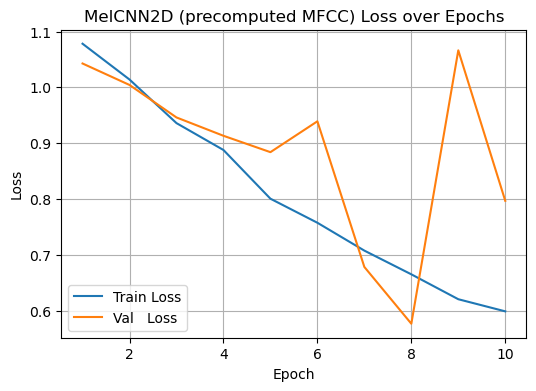

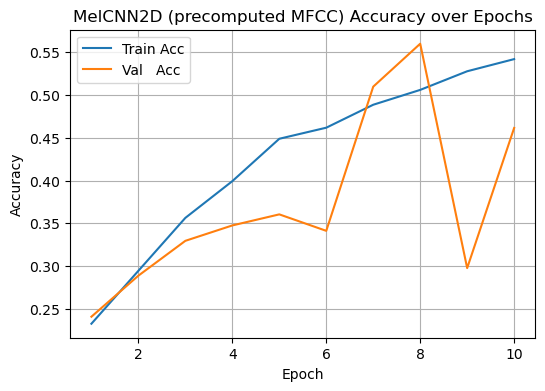

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os

# 1) Load your saved MFCC list
mfcc_list = torch.load("audio_mfccs.pt")   # list of Tensors [num_frames, n_mfcc]

# 2) Rebuild metadata so you know each file's accent
#    (must match the order you used when saving)
wav_dir = "/Users/bramdewaal/Desktop/Uni/VSC/Deep Learning/Assignment/Train"
df_meta = build_metadata(wav_dir)  # as before, yields DataFrame in the same order

assert len(mfcc_list) == len(df_meta), "Metadata & features must align"


import torch

# Cross-platform device selection
try:
    import torch_directml
    device = torch_directml.device()
    print("🚀 Using DirectML on AMD GPU:", device)
except ImportError:
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("🚀 Using Apple MPS on Apple Silicon:", device)
    else:
        device = torch.device("cpu")
        print("⚠️  Falling back to CPU:", device)
# 3) Create a Dataset that pads/trims MFCCs to a fixed frame count
class MFCCDataset(Dataset):
    def __init__(self, mfcc_list, metadata_df, max_frames=160):
        self.mfccs = mfcc_list
        self.meta  = metadata_df.reset_index(drop=True)
        self.max_frames = max_frames
        
    def __len__(self):
        return len(self.mfccs)
    
    def __getitem__(self, idx):
        m = self.mfccs[idx]            # [num_frames, n_mfcc]
        n_frames, n_mfcc = m.shape
        
        # pad or trim to max_frames
        if n_frames < self.max_frames:
            pad_amt = self.max_frames - n_frames
            pad = torch.zeros(pad_amt, n_mfcc)
            m = torch.cat([m, pad], dim=0)
        else:
            m = m[:self.max_frames]
        
        # now m is [max_frames, n_mfcc]
        x = m.T                       # → [n_mfcc, max_frames]
        x = x.unsqueeze(0)            # → [1, n_mfcc, max_frames]
        
        # normalize
        x = (x - x.mean())/(x.std()+1e-6)
        
        # label (0–4)
        y = self.meta.loc[idx, "accent"] - 1
        return x, torch.tensor(y, dtype=torch.long)

# 4) Instantiate Dataset + DataLoader
# Choose max_frames so it covers most of your signals (e.g., ~160)
ds_mfcc = MFCCDataset(mfcc_list, df_meta, max_frames=160)
loader_mfcc = DataLoader(ds_mfcc, batch_size=32, shuffle=True, num_workers=0)

# 5) Train with your MelCNN2D
mel_model, mel_history = run_experiment(
    MelCNN2D,
    train_loader=loader_mfcc,
    val_loader=loader_mfcc,    # replace with a proper val split if you have one

    num_classes=5,
    p_dropout=0.3
)

# 6) Plot curves
plot_training_curves(mel_history, model_name="MelCNN2D (precomputed MFCC)")

-----------

In [ ]:
def build_metadata(data_dir: str):
    """
    Walk through data_dir and collect file paths, accents, and genders.
    """
    records = []
    for root, _, files in os.walk(data_dir):
        for fname in files:
            if fname.lower().endswith(".wav"):
                path = os.path.join(root, fname)
                accent = int(fname[0])          # '1'–'5'
                gender = fname[1].lower()       # 'm' or 'f'
                records.append({"path": path, "accent": accent, "gender": gender})
    return pd.DataFrame(records)

In [ ]:
df = build_metadata("/Users/bramdewaal/Desktop/Uni/VSC/Deep Learning/Assignment/Train") # Training dataframe based on accent & gender metadata
